In [12]:
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
from scipy import ndimage

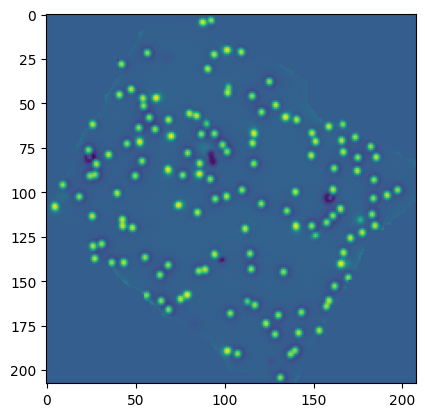

In [13]:
topo_1 = np.loadtxt("processed data/Topo_B1043_final.txt") 
plt.imshow(topo_1)

(208, 208)


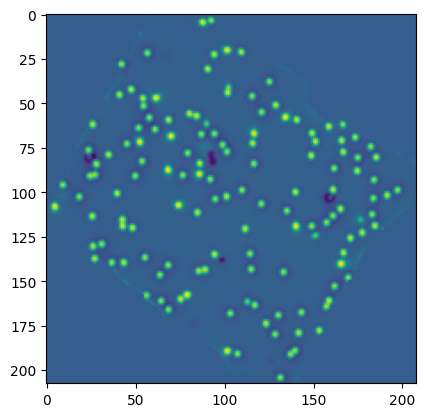

In [14]:
normalizedData = cv.normalize(topo_1, None, 0, 255, cv.NORM_MINMAX).astype('uint8')
#normalizedData = cv.medianBlur(normalizedData,5)
print(normalizedData.shape)

plt.imshow(normalizedData)

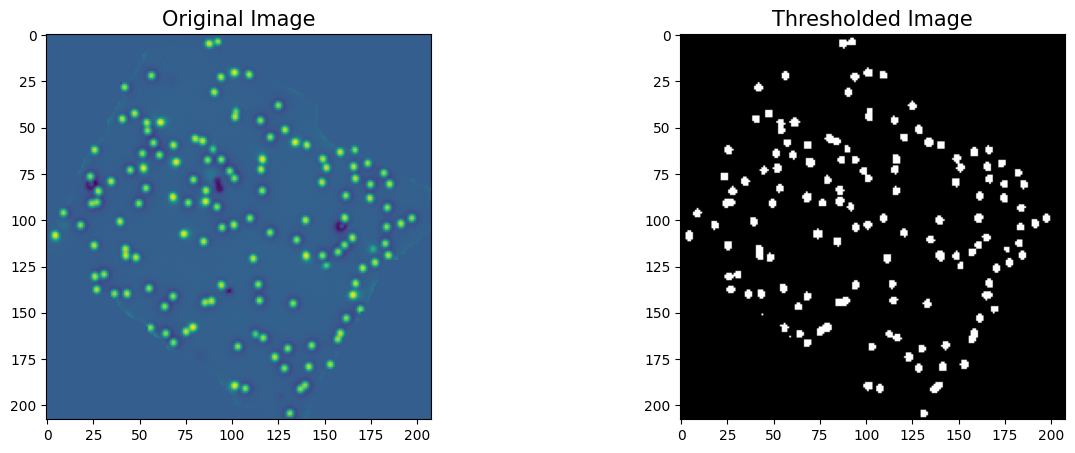

In [15]:
threshData = cv.adaptiveThreshold(normalizedData, 120, cv.ADAPTIVE_THRESH_GAUSSIAN_C,
                               cv.THRESH_BINARY,25,-29)
fig, ax = plt.subplots(1,2,figsize=(15,5))
ax[0].set_title('Original Image',fontsize=15)
ax[0].imshow(normalizedData)
ax[1].set_title('Thresholded Image',fontsize=15)
ax[1].imshow(threshData,cmap='gray')

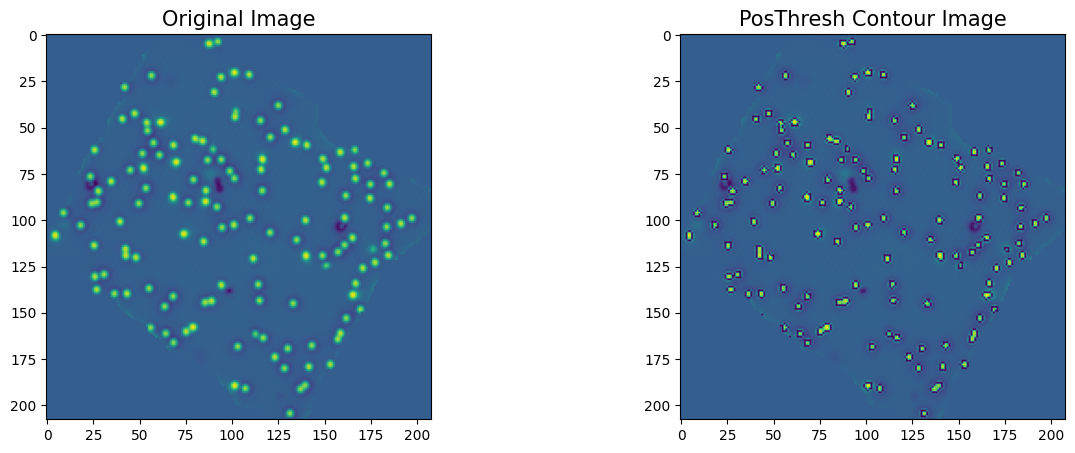

In [16]:
contours, hierarchy = cv.findContours(threshData, cv.RETR_TREE, cv.CHAIN_APPROX_NONE)
copyData = normalizedData.copy()
cv.drawContours(copyData, contours, -1, (0,255,0), 1)
fig, ax = plt.subplots(1,2,figsize=(15,5))
ax[0].set_title('Original Image',fontsize=15)
ax[0].imshow(normalizedData)
ax[1].set_title('PosThresh Contour Image',fontsize=15)
ax[1].imshow(copyData)

/var/folders/3z/md79xf1n2mndn67998_9qpfr0000gn/T/ipykernel_986/1526254598.py:1: DeprecationWarning: Please import `maximum_filter` from the `scipy.ndimage` namespace; the `scipy.ndimage.filters` namespace is deprecated and will be removed in SciPy 2.0.0.
  from scipy.ndimage.filters import maximum_filter
/var/folders/3z/md79xf1n2mndn67998_9qpfr0000gn/T/ipykernel_986/1526254598.py:2: DeprecationWarning: Please import `generate_binary_structure` from the `scipy.ndimage` namespace; the `scipy.ndimage.morphology` namespace is deprecated and will be removed in SciPy 2.0.0.
  from scipy.ndimage.morphology import generate_binary_structure, binary_erosion
/var/folders/3z/md79xf1n2mndn67998_9qpfr0000gn/T/ipykernel_986/1526254598.py:2: DeprecationWarning: Please import `binary_erosion` from the `scipy.ndimage` namespace; the `scipy.ndimage.morphology` namespace is deprecated and will be removed in SciPy 2.0.0.
  from scipy.ndimage.morphology import generate_binary_structure, binary_erosion


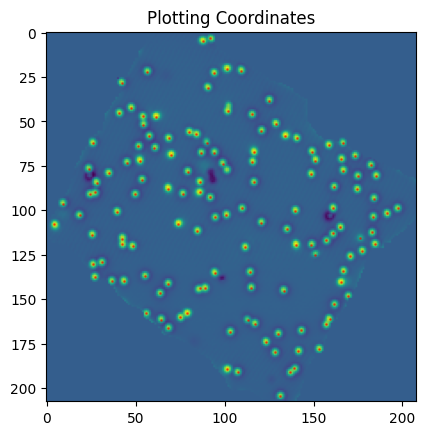

In [17]:
from scipy.ndimage.filters import maximum_filter
from scipy.ndimage.morphology import generate_binary_structure, binary_erosion
from scipy.spatial.distance import cdist

coordinates = []
match_shapes = []
circle_mask = np.zeros(normalizedData.shape)
circle = cv.circle(circle_mask,(150,150),3,255,2)

for i, count in enumerate(contours):

    area = cv.contourArea(count)
    x,y,w,h = cv.boundingRect(count)
    rect_area = w*h
    extent = float(area)/rect_area
    ret = cv.matchShapes(circle,count,1,0.0)
    match_shapes.append(ret)

    if extent<0.19:
        match_shapes[i] = 0
    
    if extent > 0.19:  #Filters out edges
        mask = np.zeros(normalizedData.shape)
        cv.drawContours(mask, [count], -1, (0, 255, 0), 1)
        kpCnt = len(count)
        x = 0
        y = 0
    
        for kp in count:
            x = x+kp[0][0]
            y = y+kp[0][1]

        coordinates.append(np.array([i,x/kpCnt, y/kpCnt]))

coordinates = np.stack(coordinates)
match_shapes = np.asarray(match_shapes)

for i, shape in enumerate(match_shapes):
    if shape > 1:
        coordinates = coordinates[coordinates[:,0] != i]

coordinates = coordinates[:,1:]

for i, count in enumerate(contours):
    if match_shapes[i] > 1:
        dimer_mask = np.zeros(normalizedData.shape)
        cv.drawContours(dimer_mask, [contours[i]], -1, 1, -1)
        region_of_interest = normalizedData * dimer_mask
        neighborhood = generate_binary_structure(2,2)
        local_max = maximum_filter(region_of_interest, footprint=neighborhood)==region_of_interest
        background = (region_of_interest==0)
        eroded_background = binary_erosion(background, structure = neighborhood, border_value =1)
        detected_peaks = local_max ^ eroded_background
        if np.where(detected_peaks == True)[0].shape[0] > 1:
            peak_coords_list = []
            for j in range(np.where(detected_peaks == True)[0].shape[0]):
                peak_coords = np.array([[np.where(detected_peaks == True)[1][j],
                                         np.where(detected_peaks == True)[0][j]]])
                peak_coords_list.append(peak_coords)

            peak_coords_list = np.asarray(peak_coords_list).reshape(np.where(detected_peaks == True)[0].shape[0],2)

            distances = cdist(peak_coords_list, peak_coords_list)
            close_peaks = np.where((distances <= 4) & (distances != 0))
            faulty_peaks = np.where((distances <= 1) & (distances != 0))
            
            peaks_to_remove = set()

            if peak_coords_list.shape[0] > 2:
                for i, j in zip(close_peaks[0], close_peaks[1]):
                    if i < j:  
                        peaks_to_remove.add(j)
            
            else:
                for i,j in zip(faulty_peaks[0], faulty_peaks[1]):
                    if i < j:
                        peaks_to_remove.add(j)

            peak_coords_list = np.delete(peak_coords_list, list(peaks_to_remove), axis=0)

            coordinates = np.concatenate((coordinates, peak_coords_list), axis=0)
        else:
            single_peak_coords = np.array([np.where(detected_peaks == True)[1],
                                         np.where(detected_peaks == True)[0]]).reshape(1,2)
            coordinates = np.concatenate((coordinates, single_peak_coords), axis=0)
                    


plt.title('Plotting Coordinates')
plt.scatter(coordinates[:,0],coordinates[:,1],s=1,c='r',alpha = 0.5)
plt.imshow(normalizedData)

In [18]:
#np.save("Topo_B1486_final_coordinates", coordinates)

## 